# USPTO Analysis
_______________

### Patents are dense
- Patents are inherently dense. Typically, the information may be understood with enough time, or preexisting domain knowledge. 

### Patent breakdown
- With each patent comes a set of pages; title page, description pages, graph pages, etc. Not all, but a lot of patents, come with a patent drawing/figure on the front page. Within that image, there are numbers to label each part of the figure; the aforementioned description pages explain what each image/figure is and what each given label on the image represents. 

### Project purpose
- The purpose of this project is to use machine learning and other data science methods to identify each image label, match that label with its' corresponding description, and convert the description to laymens terms as well; as well as condense that information. 

### Extra steps
- After this is done an additional step may be taken to take the condensed descriptions and place them next to each figure label. After the descriptions are placed, a search engine/recommendation engine may be created to allow for quicker access. 

### Benefit
- An individual can save time by searching and finding relavant patents based on either laymens terms or domain jargon. They can then gain a quicker oversite by receiving only the images with their descriptions; with the option of looking at the full paper. 

### Where did this idea come from?
- This project has grown out of a personal desire to understand patents, and feeling overwhelmed by the amount of data that there is. The hope is to make patents less of a black blox, and more of an opportunity for myself and for others. 

### Limitations
- Due to limited time, this presentation/final product for this bootcamp will only be a part of the overall project. 

## Prepare and organize your workspace
_______________
#### Below is a basic breakdown of what an image recognition project using tensorflow may look like. It's important to stay organized and keep things simple. 

```bash
Tensorflow/scripts/
└── preprocessing
    ├── generate_tfrecord.py
    └── xml_to_csv.py
```
```bash
Tensorflow/workspace/
└── patent_project
    ├── annotations
    │   ├── function_test.txt
    │   ├── function_train.txt
    │   ├── get_labels.ipynb
    │   ├── labelmap.pbtxt
    │   ├── test_labels.csv
    │   ├── testing.txt
    │   ├── train.record
    │   ├── train_labels.csv
    │   └── training.txt
    ├── images
    │   ├── tiff_to_jpg.ipynb
    │   ├── test 
    │   │   ├── tif files
    │   │   ├── xml files
    │   └── train
    │       ├── tif files
    │       └── xml files
    ├── pre-trained-model
    │   └── ssd_inception_v2_coco
    │       ├── checkpoint
    │       ├── frozen_inference_graph.pb
    │       ├── model.ckpt.data-00000-of-00001
    │       ├── model.ckpt.index
    │       ├── model.ckpt.meta
    │       ├── pipeline.config
    │       └── saved_model
    │           ├── saved_model.pb
    │           └── variables
    ├── train.py
    └── training
        ├── checkpoint
        ├── events.out.tfevents
        ├── model.ckpt-0.data-00000-of-00001
        ├── model.ckpt-0.index
        ├── model.ckpt-0.meta
        └── ssd_inception_v2_coco.config
```
- Set path when new terminal is opened. 
- !export PYTHONPATH=$PYTHONPATH:/Users/home/Documents/TensorFlow/models/research:/Users/home/Documents/TensorFlow/models/research/slim


## Convert images to correct format
_______________
#### The images that I downloaded in bulk from the uspto website came in a tiff format. Tensorflow doesn't support this so we need to convert it to a format such as jpg.

```
import os
from PIL import Image

path = '/Users/home/Documents/Tensorflow/workspace/patent_project/images/'
for root, dirs, files in os.walk(path, topdown=False):
    for name in files:
        print(os.path.join(root, name))
        if os.path.splitext(os.path.join(root, name))[1].lower() == ".tif":
            if os.path.isfile(os.path.splitext(os.path.join(root, name))[0] + ".jpg"):
                print("A jpg file already exists for %s" % name)
            # If a jpeg is *NOT* present, create one from the tiff.
            else:
                outfile = os.path.splitext(os.path.join(root, name))[0] + ".jpg"
                try:
                    im = Image.open(os.path.join(root, name))
                    print("Generating jpeg for %s" % name)
                    im.thumbnail(im.size)
                    im.save(outfile, "JPEG", quality=100)
                except Exception as e:
                    print(e)
```

## Annotate images
_______________
#### Using labelImg you can annotate your images by placing bounding boxes around the items that you want to identify, this then creates an xml file for each image that has the bounding box boundries for each image and its' item. 

#### Once we have our xml files we can convert them into a single csv file:

```
import os
import glob
import pandas as pd
import argparse
import xml.etree.ElementTree as ET

def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (
                    root.find('filename').text, int(root.find('size')[0].text),
                    int(root.find('size')[1].text), member[0].text,
                    int(member[4][0].text), int(member[4][1].text),
                    int(member[4][2].text), int(member[4][3].text)
                    )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

def main():
    parser = argparse.ArgumentParser(description="XML-to-CSV")
    parser.add_argument("-i", "--inputDir", help="Path to xml folder", type=str)
    parser.add_argument("-o", "--outputFile", help="Output path to csv folder", type=str)
    args = parser.parse_args()
    if(args.inputDir is None):
        args.inputDir = os.getcwd()
    if(args.outputFile is None):
        args.outputFile = args.inputDir + "/labels.csv"
    assert(os.path.isdir(args.inputDir))
    xml_df = xml_to_csv(args.inputDir)
    xml_df.to_csv(args.outputFile, index=None)
    print('Converted xml to csv.')

if __name__ == '__main__':
    main()
```    

## Get labels
_______________
#### Due to the number of total possible labels that we could have for our patent images it's best to create a script to turn our csv labels into our .pbtxt items.

#### - First we create a txt file with all of the image labels: -

```
import pandas as pd

# Grab Training labels
filename = 'train_labels.csv'
file = pd.read_csv(filename,header=None)
file = file[3]
end = '\n'
s = ' '
ID = 1
name = 'training.txt'
for x in file[1:]:
    out = ''
    out += 'item' + s + '{' + end
    out += s*2 + 'id:' + ' ' + (str(ID)) + end
    out += s*2 + 'name:' + ' ' + '\'' + str(x) + '\'' + end
    out += '}' + end    
    ID += 1
    with open(name, 'a') as f:
        f.write(out)
        
# Grab Testing labels
filename = 'test_labels.csv'
file = pd.read_csv(filename,header=None)
file = file[3]
end = '\n'
s = ' '
ID = ID
name = 'testing.txt'
for x in file[1:]:
    out = ''
    out += 'item' + s + '{' + end
    out += s*2 + 'id:' + ' ' + (str(ID)) + end
    out += s*2 + 'name:' + ' ' + '\'' + str(x) + '\'' + end
    out += '}' + end    
    ID += 1
    with open(name, 'a') as f:
        f.write(out)     
```

#### - Then we our if else statement using the .txt to create a our tfrecords file: -

```
# generate_tfrecord if else statement
# Testing
filename = 'test_labels.csv'
file = pd.read_csv(filename,header=None)
file = file[3]
end = '\n'
s = ' '
ID = 0
name = 'function_test.txt'
for x in file[2:]:
    out = ''
    out += 'elif row_label == \'' + str(x) + '\':' + end
    out += s*4 + 'return ' + str(ID) + end
    ID += 1
    with open(name, 'a') as f:
        f.write(out)
        
# Training
filename = 'train_labels.csv'
file = pd.read_csv(filename,header=None)
file = file[3]
end = '\n'
s = ' '
ID = ID
name = 'function_train.txt'
for x in file[2:]:
    out = ''
    out += 'elif row_label == \'' + str(x) + '\':' + end
    out += s*4 + 'return ' + str(ID) + end
    ID += 1
    with open(name, 'a') as f:
        f.write(out)
```

#### - From the above code we can copy and paste the results into the 'class_text_to_int()' function below -

```
from __future__ import print_function
from __future__ import absolute_import
import os
import io
import pandas as pd
import tensorflow as tf
import sys
sys.path.append("../../models/research")

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

flags = tf.app.flags
flags.DEFINE_string('csv_input', '', 'Path to the CSV input')
flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
flags.DEFINE_string('label', '', 'Name of class label')
flags.DEFINE_string('img_path', '', 'Path to images')
FLAGS = flags.FLAGS

def class_text_to_int(row_label):
    if row_label == 'patent image':
        return 1
    return None

def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    # check if the image format is matching with your images.
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example
def main(_):
    writer = tf.python_io.TFRecordWriter(FLAGS.output_path)
    path = os.path.join(os.getcwd(), FLAGS.img_path)
    examples = pd.read_csv(FLAGS.csv_input)
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), FLAGS.output_path)
    print('Created TFRecords: {}'.format(output_path))

if __name__ == '__main__':
    tf.app.run()
```

## Transfer Learning
_______________
#### Tensorflow comes with a handful of models that are pretrained. We're actually able to take any of the pretrained models, take the calculated weights for any of the given models, and use those weights to train the set of annotated images that we created. 

#### I decided to go with the 'ssd_inception_v2_coco' model simply because it seemed like a good middle ground for speed and accuracy.

#### Once we have downloaded our pretrained model we can customize the config file to the number of files to files that we have creating up to this point:

```
model {
  ssd {
    num_classes: 1 # this is the number of different labels that we came across when annotating our patent images.
    image_resizer {
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    feature_extractor {
      type: "ssd_inception_v2"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.99999989895e-05
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.0299999993294
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.999700009823
          center: true
          scale: true
          epsilon: 0.0010000000475
          train: true
        }
      }
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    box_predictor {
      convolutional_box_predictor {
        conv_hyperparams {
          regularizer {
            l2_regularizer {
              weight: 3.99999989895e-05
            }
          }
          initializer {
            truncated_normal_initializer {
              mean: 0.0
              stddev: 0.0299999993294
            }
          }
          activation: RELU_6
        }
        min_depth: 0
        max_depth: 0
        num_layers_before_predictor: 0
        use_dropout: false
        dropout_keep_probability: 0.800000011921
        kernel_size: 3
        box_code_size: 4
        apply_sigmoid_to_scores: false
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.20000000298
        max_scale: 0.949999988079
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_ratios: 0.5
        aspect_ratios: 3.0
        aspect_ratios: 0.333299994469
        reduce_boxes_in_lowest_layer: true
      }
    }
    post_processing {
      batch_non_max_suppression {
        score_threshold: 0.300000011921
        iou_threshold: 0.600000023842
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
    normalize_loss_by_num_matches: true
    loss {
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      classification_loss {
        weighted_sigmoid {
        }
      }
      hard_example_miner {
        num_hard_examples: 3000
        iou_threshold: 0.990000009537
        loss_type: CLASSIFICATION
        max_negatives_per_positive: 3
        min_negatives_per_image: 0
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
  }
}
train_config {
  batch_size: 24 # Good friends don't let you do batch sizes over 32. 
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    ssd_random_crop {
    }
  }
  optimizer {
    rms_prop_optimizer {
      learning_rate {
        exponential_decay_learning_rate {
          initial_learning_rate: 0.00400000018999
          decay_steps: 800720
          decay_factor: 0.949999988079
        }
      }
      momentum_optimizer_value: 0.899999976158
      decay: 0.899999976158
      epsilon: 1.0
    }
  }
  fine_tune_checkpoint: "ssd_inception_v2_coco_2018_01_28/model.ckpt"
  from_detection_checkpoint: true
  num_steps: 200000
}
train_input_reader {
  label_map_path: 'data/object-detection.pbtxt'
  tf_record_input_reader {
    input_path: 'data/train.record'
  }
}
eval_config {
  num_examples: 8000
  max_evals: 10
  use_moving_averages: false
}
eval_input_reader {
  label_map_path: 'data/object-detection.pbtxt'
  shuffle: false
  num_readers: 1
  tf_record_input_reader {
    input_path: 'data/test.record'
  }
}
```

## Training our model
_______
#### once we have all of the above code we can run a few commands to run all of the code and train our model: 

In [4]:
# - Create xml to csv train data:
!python /Users/home/Documents/Tensorflow/scripts/preprocessing/xml_to_csv.py \
-i /Users/home/Documents/Tensorflow/workspace/training_demo/images/train \
-o /Users/home/Documents/Tensorflow/workspace/training_demo/annotations/train_labels.csv

# - Create xml to csv test data:
!python /Users/home/Documents/Tensorflow/scripts/preprocessing/xml_to_csv.py \
-i /Users/home/Documents/Tensorflow/workspace/training_demo/images/test \
-o /Users/home/Documents/Tensorflow/workspace/training_demo/annotations/test_labels.csv

# - Create record train data:
!python \
/Users/home/Documents/Tensorflow/scripts/preprocessing/generate_tfrecord.py \
--label=patent \
--csv_input=/Users/home/Documents/Tensorflow/workspace/training_demo/annotations/train_labels.csv\
--img_path=/Users/home/Documents/Tensorflow/workspace/training_demo/images/train \
--output_path=/Users/home/Documents/Tensorflow/workspace/training_demo/annotations/train.record

# - Create record test data:
!python /Users/home/Documents/Tensorflow/scripts/preprocessing/generate_tfrecord.py \
--label=patent \
--csv_input=/Users/home/Documents/Tensorflow/workspace/training_demo/annotations/test_labels.csv \
--img_path=/Users/home/Documents/Tensorflow/workspace/training_demo/images/test \
--output_path=/Users/home/Documents/Tensorflow/workspace/training_demo/annotations/test.record


Successfully converted xml to csv.
Successfully converted xml to csv.
Successfully created the TFRecords: /Users/home/Documents/Tensorflow/workspace/training_demo/annotations/train.record
Successfully created the TFRecords: /Users/home/Documents/Tensorflow/workspace/training_demo/annotations/test.record


#### Below is an example output for our model. It shows an approximate loss of 2. Ideally we want a loss of around 1.

```
INFO:tensorflow:global step 2748: loss = 1.8951 (88.086 sec/step)
INFO:tensorflow:global step 2748: loss = 1.8951 (88.086 sec/step)
INFO:tensorflow:global step 2749: loss = 2.1281 (25.003 sec/step)
INFO:tensorflow:global step 2749: loss = 2.1281 (25.003 sec/step)
INFO:tensorflow:global_step/sec: 0.0188623
INFO:tensorflow:global_step/sec: 0.0188623
INFO:tensorflow:Recording summary at step 2749.
INFO:tensorflow:Recording summary at step 2749.
INFO:tensorflow:global step 2750: loss = 2.0793 (20.090 sec/step)
INFO:tensorflow:global step 2750: loss = 2.0793 (20.090 sec/step)
INFO:tensorflow:global step 2751: loss = 1.9906 (11.665 sec/step)
INFO:tensorflow:global step 2751: loss = 1.9906 (11.665 sec/step)
INFO:tensorflow:global step 2752: loss = 1.7650 (13.071 sec/step)
INFO:tensorflow:global step 2752: loss = 1.7650 (13.071 sec/step)
```

#### Once we run our model an event file will be created. This is where we can evaluate our model. 

In [7]:
# - Tensorboard Allows us to see different aspects of our data.
!tensorboard --logdir='/Users/home/Documents/machine_learning/models-master/models/research/object_detection/training'

Object Detection <br>
Object detection inference - This will walk you through a pre-trained model to detect patent objects in an image. <br>This notebook is using a process known as transfer learning; instead of training our own model from scratch, we use the weights from a pre-trained model. <br>This allows us to save time, but may come at a cost to accuracy. 

In [39]:
import os
import sys
import tarfile
import zipfile
import numpy as np
import tensorflow as tf
import six.moves.urllib as urllib
from object_detection.utils import ops as utils_ops
from utils import visualization_utils as vis_util # Object detection module import
from distutils.version import StrictVersion
from matplotlib import pyplot as plt
from collections import defaultdict
from utils import label_map_util # Object detection module import
from io import StringIO
from PIL import Image

%matplotlib inline

We use an "SSD with Mobilenet" model:

In [41]:
MODEL_NAME = '/Users/home/Documents/machine_learning/models-master/models/research/object_detection/patent_image_inference_graph' # Download model.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb' # Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_LABELS = os.path.join('/Users/home/Documents/machine_learning/models-master/models/research/object_detection/data/', 'object-detection.pbtxt') # Adds label for each box.

Load frozen Tensorflow model into memory:

In [42]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

Load label map:<br>
Label maps map indices to category names, so that when our convolution network predicts `1`, we know that this corresponds to `patent image`.

In [43]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [44]:
def load_image_into_numpy_array(image):
    # Function supports only grayscale images
    last_axis = -1
    dim_to_repeat = 2
    repeats = 3
    grscale_img_3dims = np.expand_dims(image, last_axis)
    training_image = np.repeat(grscale_img_3dims, repeats, dim_to_repeat).astype('uint8')
    assert len(training_image.shape) == 3
    assert training_image.shape[-1] == 3
    return training_image

Detection:

In [48]:
PATH_TO_TEST_IMAGES_DIR = '/Users/home/Documents/machine_learning/models-master/models/research/object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(3, 12) ]
IMAGE_SIZE = (20, 15)

In [49]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            
            for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes', 'detection_masks']:
                tensor_name = key + ':0' 
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
                    
            if 'detection_masks' in tensor_dict:
                # The following processing is only for a single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(detection_masks, detection_boxes, image.shape[1], image.shape[2])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: image})

            # all outputs are float32 numpy arrays; convert types as needed
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.int64)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

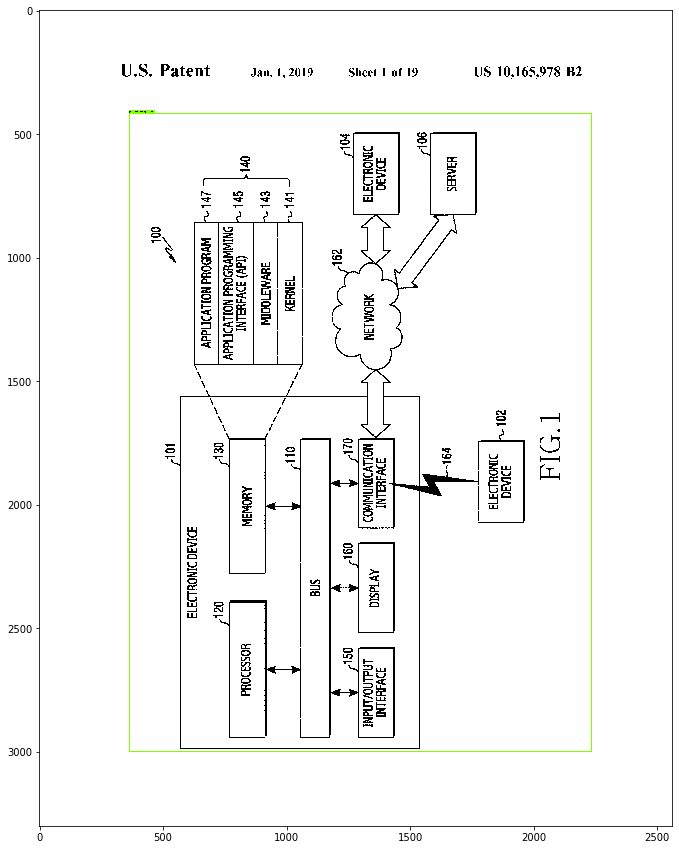

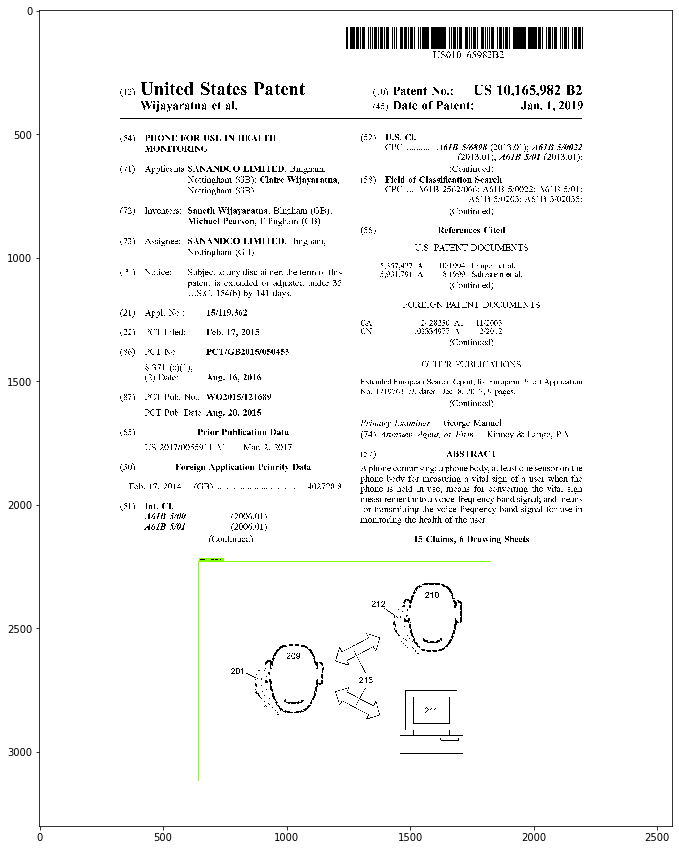

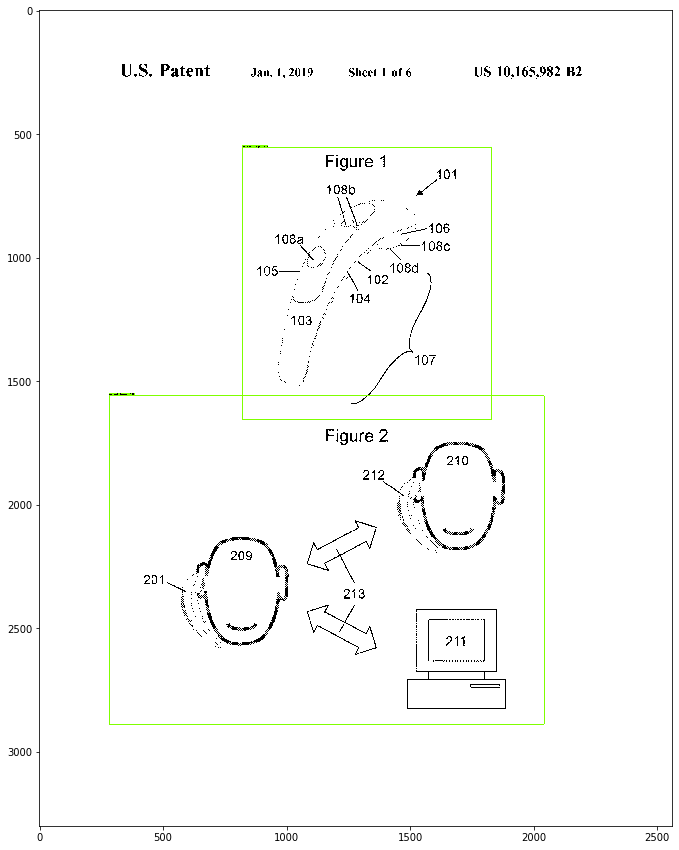

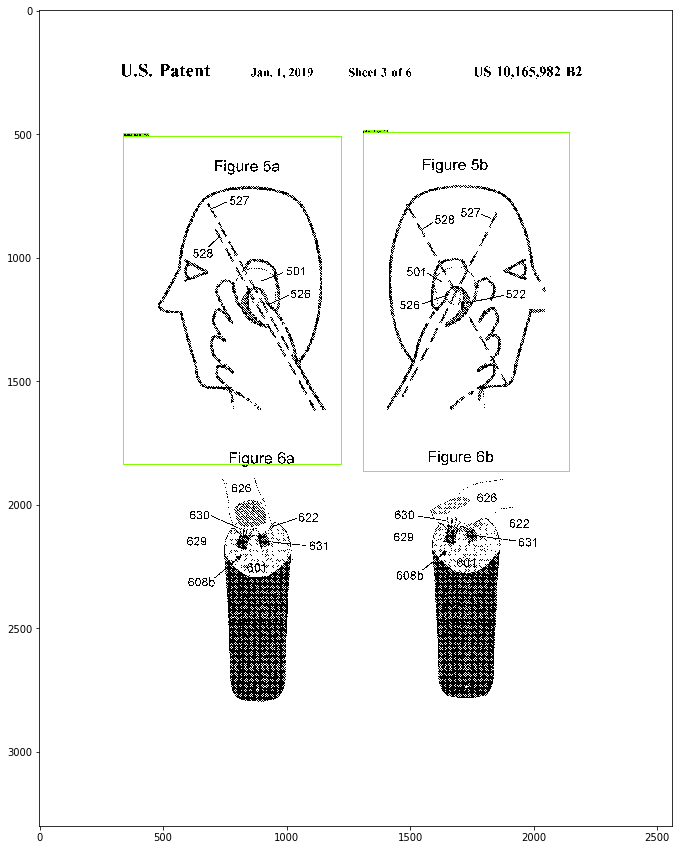

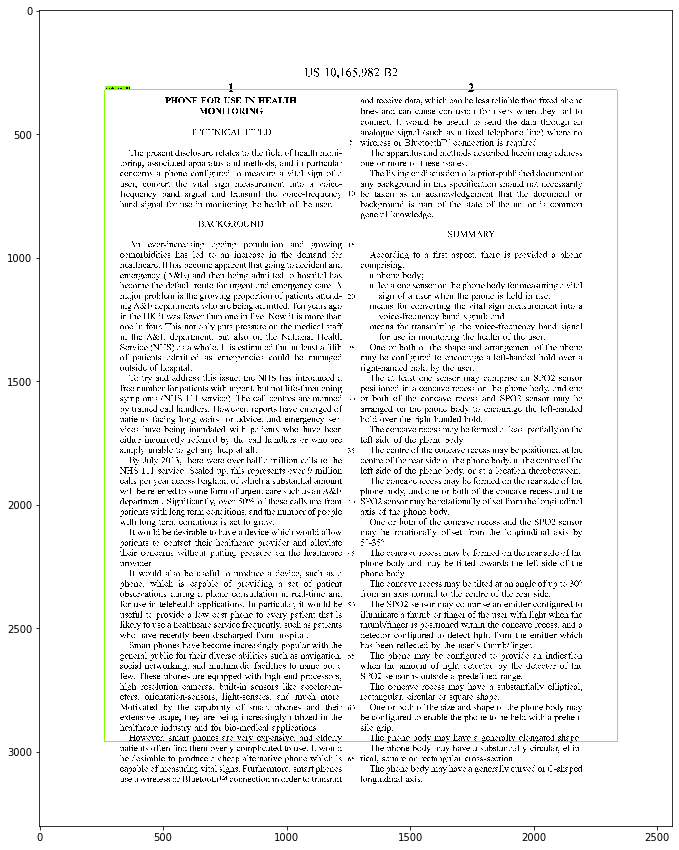

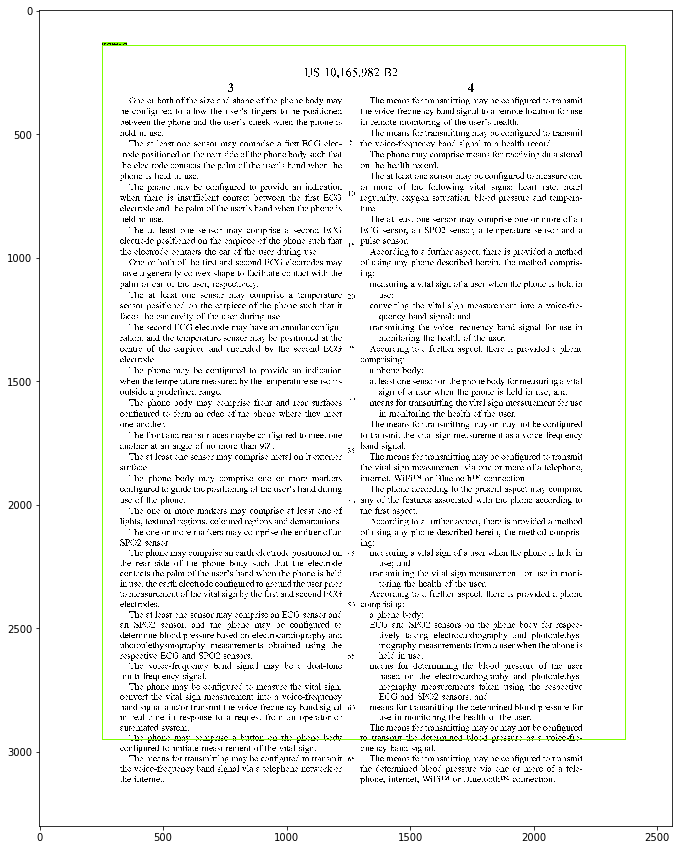

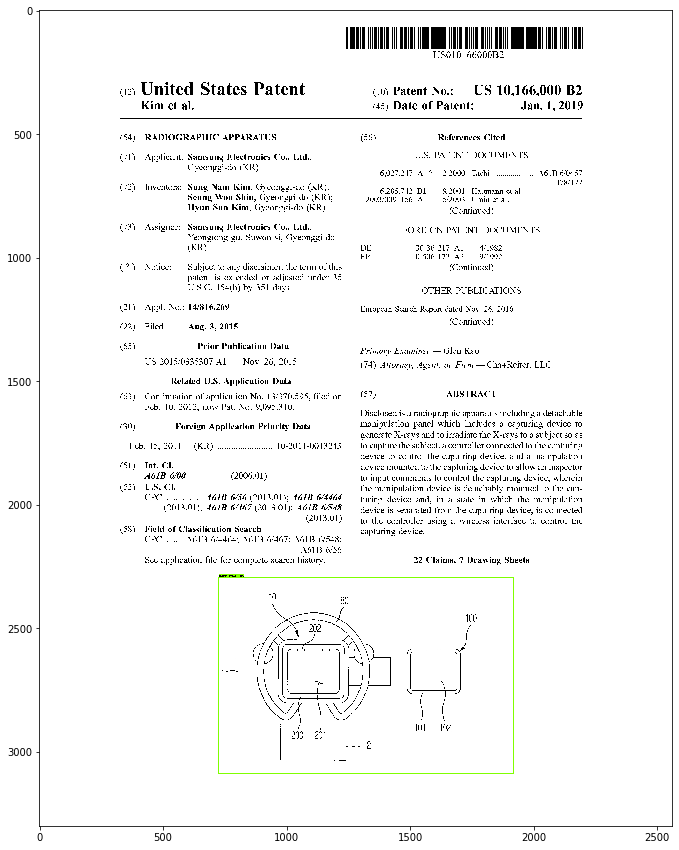

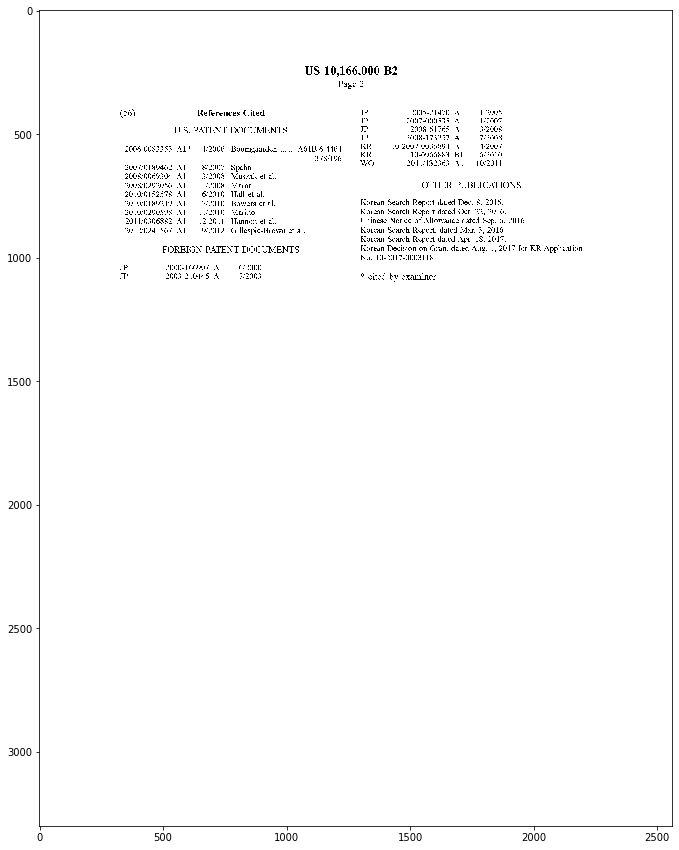

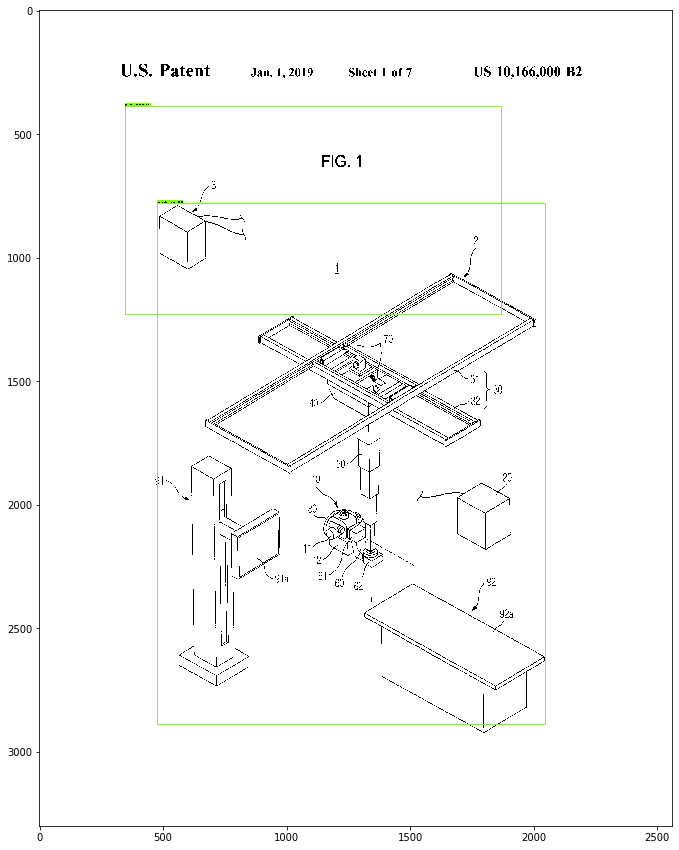

In [50]:
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # Array representation of image will be used later to prepare result image w/ boxes &* labels.
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)     # Actual detection.
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(image_np,
                                                       output_dict['detection_boxes'],
                                                       output_dict['detection_classes'],
                                                       output_dict['detection_scores'],
                                                       category_index,
                                                       instance_masks=output_dict.get('detection_masks'),
                                                       use_normalized_coordinates=True,
                                                       line_thickness=4)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

### Next steps:
- Train object detection model longer and with more images to get loss down to an aproximated 1. 
- Train new object detection model to detect image figure numbers.
- Parse patent text data to tokenize and formalize patent image data and image figures data.
- Match formalized text data with image and image figures. 
- Create user-interface. 

In [1]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to had
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))